# This jupyter notebook translate VERT_FSFB.m by Gabriel A. Vecchi(May 12, 1998)
## and tested it with a constant $N^2 = 10^{-6}$ profile

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
data_length = 40
data_step = 10

In [4]:
N2_uniform = np.repeat(1e-6, data_length)
Pmid_uniform = np.arange(5, 400, data_step)

In [5]:
Pmid_uniform.shape, N2_uniform.shape, Pmid_uniform

((40,),
 (40,),
 array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
        135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255,
        265, 275, 285, 295, 305, 315, 325, 335, 345, 355, 365, 375, 385,
        395]))

In [6]:
def INTEGRATOR(M, Dz): 
    
    #    Generates and integration matrix.
    #    Integrates from first point to each point.
    
    INT = np.tril(np.ones(M))
    INT = INT - 0.5 * (np.eye(M))
    INT[:,0] = INT[:,0] - 0.5
    INT = INT * Dz
    
    return INT

In [7]:
def  VERT_FSFB3_BT(N2_uniform, Pmid_uniform):
    
    import numpy as np
    import scipy
    import gsw
    from numpy import linalg as LA
    
    for i in range(len(N2_uniform)):
        if N2_uniform[i] < 0:
            N2_uniform[i] = np.min(np.absolute(N2_uniform))
    
    Dz = np.median(np.diff(Pmid_uniform))
    Dzrng = np.max(np.diff(Pmid_uniform)) - np.min(np.diff(Pmid_uniform))
    
    if(Dzrng > 1e-3 * Dz):
        print('Dz is not constant!!')
    # else: print('Dz is constant.')
    
    # add a point for the surface
    # note that this means that Psi has one more depth than N2!!
    M = len(N2_uniform) + 1
    print(M)
    #  Fill in D - the differential operator matrix.
    #  Surface (repeat N2 from midpoint depth)
    D = np.zeros([M, M]) # Make a M x M zero array
    
    D[0, 0] = -2/N2_uniform[0]
    D[0, 1] = 2/N2_uniform[0]

    # Interior
    for i in range(1, M-1):
        D[i, i-1] = 1/N2_uniform[i-1]
        D[i, i] = -1/N2_uniform[i-1] - 1/N2_uniform[i]
        D[i, i+1] = 1/N2_uniform[i]

    # Bottom
    #D[M-1, M-2] = 1/N2_uniform[M-2]
    D[M-1, M-2] = 2/N2_uniform[M-2]
    D[M-1, M-1]  = -2/N2_uniform[M-2]
    D = -1 * D / (Dz * Dz)
    
    # BDC: D should be a tridiagonal matrix
    # Calculate generalized eigenvalue problem
    Lambda, Psi = LA.eig(D)
    # LA.eig() Compute the eigenvalues and right eigenvectors of a square array.
    # Lambda:    The eigenvalues, each repeated according to its multiplicity.
    # Psi: The normalized (unit "length") eigenvectors, such that the 
    # column ``Psi[:,i]`` is the eigenvector corresponding to the eigenvalue Lambda[i].
    
    # Remove Barotropic Mode 
    # lambda = 1/(radius of deformation * f)^2 (m/s)^{-2}
    # BT mode, rd = infinity. hence lambda = 0.
    #ind = np.where(Lambda >= 1e-10)
    #Lambda = Lambda[ind]
    #Psi = Psi[ind]
    print(Psi.shape)
    
    # Sort eigenvalues and eigenvectors
    idx = np.argsort(Lambda)
    Lambda_sorted = Lambda[idx]
    print(Psi.shape)
    Psi_sorted = Psi[:, idx]
    print(Psi_sorted.shape)
    #Lambda_sorted = np.sort(Lambda)
    c2 = 1 / Lambda_sorted # Modal Speed
    
    # reference to top value
    for i in range(Psi_sorted.shape[1]):
        Psi_sorted[:, i] = Psi_sorted[:, i] / Psi_sorted[0, i]
    
    INT = INTEGRATOR(M, Dz)
    #print(INT.shape, Psi_sorted.transpose().shape)
    G = np.matmul(INT, Psi_sorted.transpose())

    return c2, Psi, G, N2_uniform, Pmid_uniform 

In [8]:
c2, Psi, G, N2, Pmid = VERT_FSFB3_BT(N2_uniform, Pmid_uniform)

41
(41, 41)
(41, 41)
(41, 41)


In [9]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [10]:
SSH = G/g
SSH.shape

(41, 41)

In [11]:
Zmid = np.flip(gsw.z_from_p(np.sort(Pmid), lat = 30))
Zmid

array([-391.93752845, -382.02427133, -372.11053751, -362.19632684,
       -352.28163918, -342.36647438, -332.4508323 , -322.53471278,
       -312.61811569, -302.70104086, -292.78348815, -282.86545742,
       -272.94694852, -263.0279613 , -253.10849562, -243.18855131,
       -233.26812825, -223.34722627, -213.42584524, -203.503985  ,
       -193.5816454 , -183.65882631, -173.73552756, -163.81174901,
       -153.88749052, -143.96275193, -134.0375331 , -124.11183387,
       -114.18565411, -104.25899366,  -94.33185237,  -84.40423009,
        -74.47612669,  -64.547542  ,  -54.61847588,  -44.68892818,
        -34.75889875,  -24.82838745,  -14.89739412,   -4.96591861])

In [12]:
Z = np.arange(0, -410, -1 * data_step)
Z.shape, SSH.shape, Zmid.shape

((41,), (41, 41), (40,))

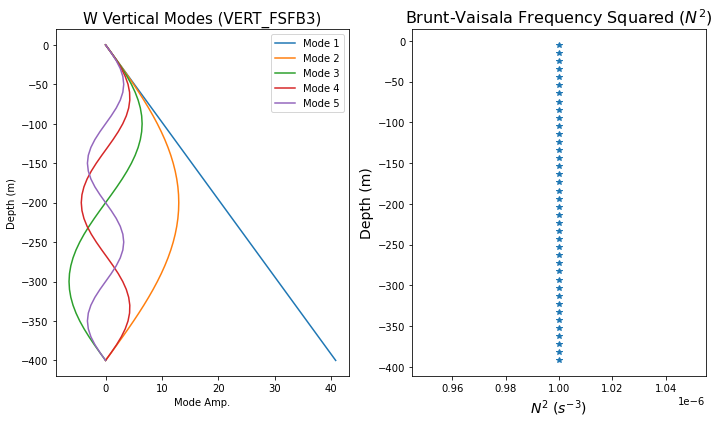

In [20]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(SSH[:,0], Z, label = 'Mode 1')
plt.plot(SSH[:,1], Z, label = 'Mode 2')
plt.plot(SSH[:,2], Z,label = 'Mode 3')
plt.plot(SSH[:,3], Z, label = 'Mode 4')
plt.plot(SSH[:,4], Z, label = 'Mode 5')
plt.xlabel('Mode Amp.')
plt.ylabel('Depth (m)')
#plt.xlim([-.2, .2])
plt.legend()
plt.title('W Vertical Modes (VERT_FSFB3)', fontsize = 15)

plt.subplot(122)
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot(N2_uniform, Zmid,  '*')
#plt.plot(Pmid_vector[:], N2_vector,  linewidth  = 2.0)
plt.xlabel('$N^2$ ($s^{-3}$)', fontsize = 14)
plt.ylabel('Depth (m)', fontsize = 14)
#plt.xlim([10, 350])
#plt.ylim([0, 0.0002])

plt.tight_layout()
plt.savefig('vertical_modes_N2_constant.png')

In [21]:
 N2_uniform

array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06])

In [22]:
MODE = 41

In [23]:
Zgrid, mode = np.meshgrid(np.append(Zmid, 0), range(MODE) )

In [24]:
mode.shape, Zgrid.shape, SSH[:].T.shape

((41, 41), (41, 41), (41, 41))

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_34175/2791508122.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mode, Zgrid, SSH[:], cmap = cmo.cm.balance)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_34175/2791508122.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(mode, Zgrid,G[:], cmap = cmo.cm.curl)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_34175/2791508122.py:18: RuntimeWarning

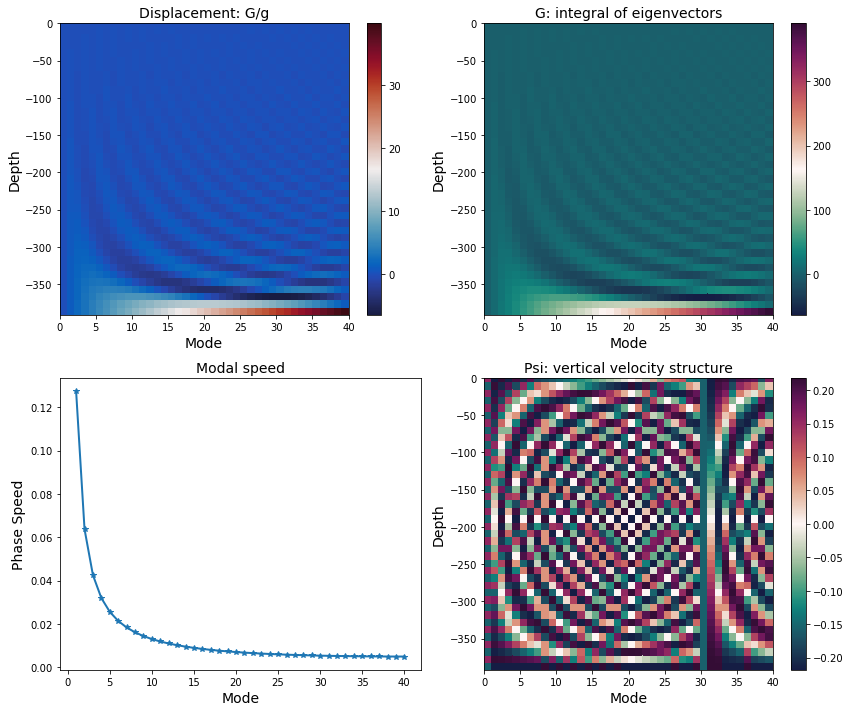

In [25]:
plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title('Displacement: G/g', fontsize = 14)
plt.pcolormesh(mode, Zgrid, SSH[:], cmap = cmo.cm.balance)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(222)
plt.title('G: integral of eigenvectors', fontsize = 14)
plt.pcolor(mode, Zgrid,G[:], cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(223)
plt.title('Modal speed' , fontsize = 14)
plt.plot(np.sqrt(c2[:]), "-*", linewidth = 2)
plt.ylabel('Phase Speed', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
#plt.colorbar()

plt.subplot(224)
plt.title('Psi: vertical velocity structure' , fontsize = 14)
plt.pcolor(mode, Zgrid, Psi[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.tight_layout()
plt.savefig('vertical_modes_FSFB2_N2_constant.png', dpi = 100)

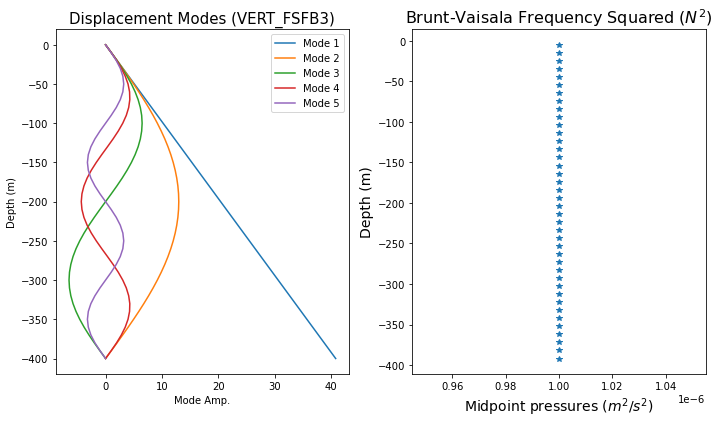

In [26]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(SSH[:,0], Z, label = 'Mode 1')
plt.plot(SSH[:,1], Z, label = 'Mode 2')
plt.plot(SSH[:,2], Z,label = 'Mode 3')
plt.plot(SSH[:,3], Z, label = 'Mode 4')
plt.plot(SSH[:,4], Z, label = 'Mode 5')
plt.xlabel('Mode Amp.')
plt.ylabel('Depth (m)')
#plt.xlim([-.2, .2])
plt.legend()
plt.title('Displacement Modes (VERT_FSFB3)', fontsize = 15)

plt.subplot(122)
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot( N2_uniform, Zmid,  '*')
#plt.plot(Pmid_vector[:], N2_vector,  linewidth  = 2.0)
plt.xlabel('Midpoint pressures (${m^2}/{s^2}$)', fontsize = 14)
plt.ylabel('Depth (m)', fontsize = 14)
#plt.xlim([10, 350])
#plt.ylim([0, 0.0002])

plt.tight_layout()
plt.savefig('vertical_modes_N2_constant.png')